<a href="https://colab.research.google.com/github/anitamezzetti/financial_big_data/blob/main/HienVersion_FinBigData_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
student1 = "Anita Mezzetti"
student2 = "Hien Lê"

Complementary stuff:
* Drive Folder to save data, notebooks and models

Note: project has been linked to [Github](https://github.com/anitamezzetti/financial_big_data)!

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # make sure to add the .ipynb files to the Colab Notebooks folder first if not already done

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks" # checking the content of the folder

arrow				JPN.csv
arrow-0.17.0.dist-info		__pycache__
CHE.csv				python_dateutil-2.8.1.dist-info
CHN.csv				six-1.15.0.dist-info
dateutil			six.py
HienVersion_FinBigData_1.ipynb	USA.csv


In [ ]:
import os 
import sys

root = "/content/drive/My Drive/Colab Notebooks" # define name of folder
nb_path = "/content/notebooks"
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)

In [ ]:
#!pip install arrow  # if arrow is already in directory, no need to install again

## Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# other libraries here
import requests
import arrow

In [ ]:
# The following snippet gets data for the 4 countries from a proxy API, but it seems that the database in this API is not up-to-date
# jh_data = requests.get('https://covid19api.herokuapp.com/confirmed')

# res_dict = jh_data.json()["locations"]
# df_res = pd.json_normalize(res_dict)
# df_res = df_res.drop(columns=["country_code", "latest", "province", "coordinates.latitude", "coordinates.longitude"])

# countries_of_interest = ["US", "Switzerland", "Japan", "China"]

# df_china = df_res[df_res.country == "China"].set_index("country")
# df_china = pd.DataFrame(df_china.sum(axis=0), columns=["China"]).T

# df = df_res[df_res.country.isin(countries_of_interest[:3])].set_index("country")
# df = pd.concat([df, df_china])

In [ ]:
# TODO: we need to decide on a fixed END date!

countries_of_interest = ["USA", "CHE", "JPN", "CHN"]

endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-02-25"
end_date = arrow.utcnow().shift(days=-1).format("YYYY-MM-DD") # yesterday
dfs = {} # dfs of cumulative confirmed cases
for country in countries_of_interest:
    query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
    res = requests.get(query).json()
    df = pd.DataFrame(res["result"])
    df.index = pd.DatetimeIndex(df["date"], tz="utc")
    df.drop(columns=["date"])
    df["date"] = pd.to_datetime(df["date"])
    df["ts_in_secs"] = df["date"].astype(int)
    df["new_confirmed"] = df["confirmed"].diff().fillna(0)
    df.to_csv(f"{root}/{country}.csv")
    dfs[country] = df

## Analysis

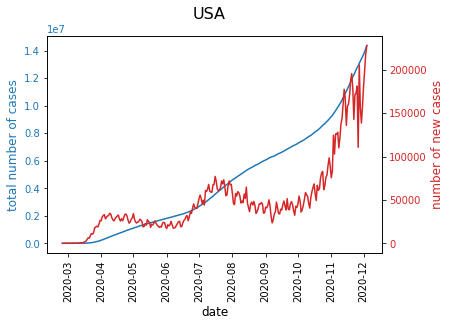

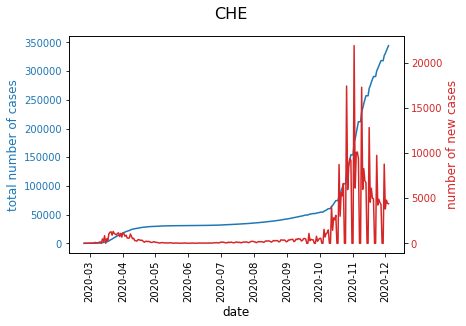

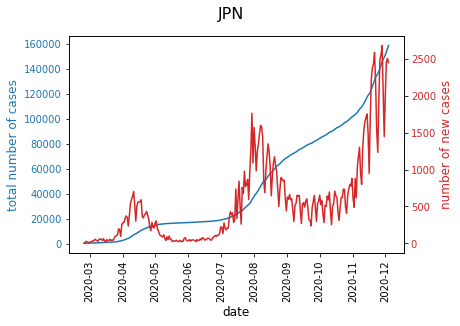

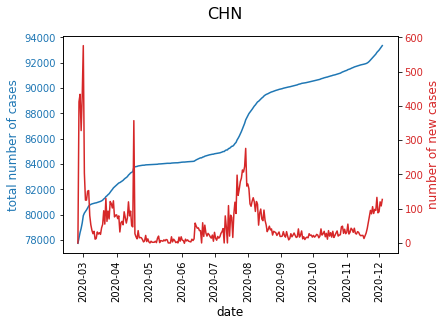

In [ ]:
# first overview
for country,df in dfs.items():  
    fig,ax1 = plt.subplots()
    ax1.plot(df.index, df["confirmed"])
    ax1.set_xlabel("date", size=12)
    ax1.tick_params(labelrotation=90, axis="x")
    color = "tab:blue"
    ax1.set_ylabel("total number of cases", color=color, size=12)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()
    color="tab:red"
    ax2.plot(df.index, df["new_confirmed"], color=color)
    ax2.set_ylabel("number of new cases", color=color, size=12)
    ax2.tick_params(axis="y", labelcolor=color)
    fig.suptitle(country, size=16)

    #fig.tight_layout()  
    plt.show()

### Per month

The boxplots below show (potentially) the month(s) where these countries experienced a jump or a big change in the number of new cases. For example, Switzerland experienced some very fast increase in cases in October and November which caused the boxplots to be so wide and with even outliers.

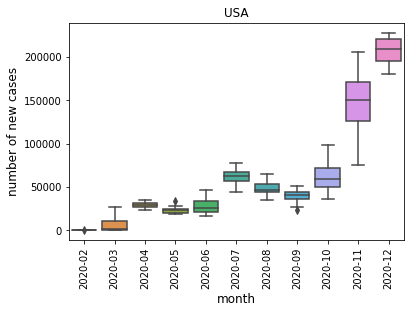

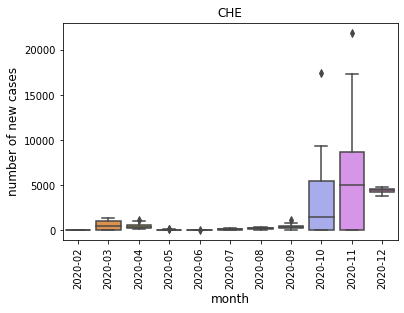

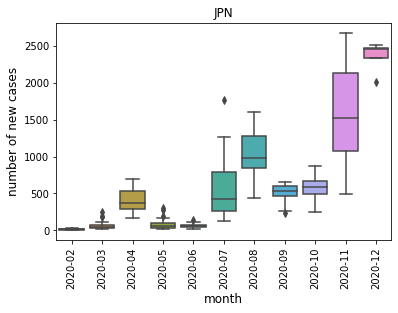

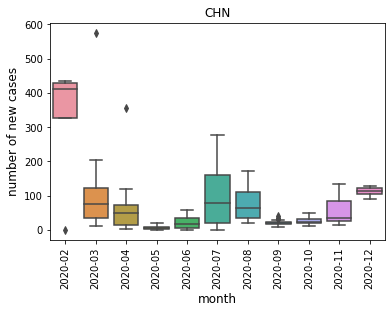

In [ ]:
for country,df in dfs.items():
    df["month"] = df["date"].dt.to_period("M")
    plt.figure()
    sns.boxplot(data=df, x="month", y="new_confirmed")
    plt.xticks(rotation=90)
    plt.xlabel("month", size=12)
    plt.ylabel("number of new cases", size=12)
    plt.title(country)
    plt.show()

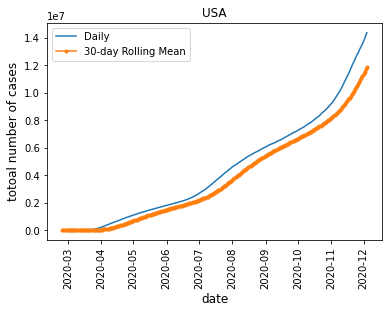

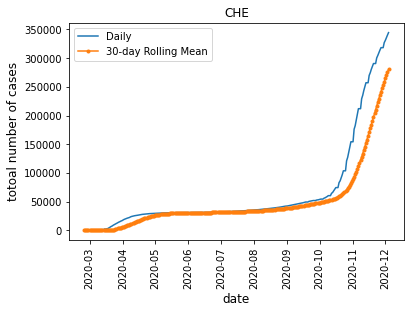

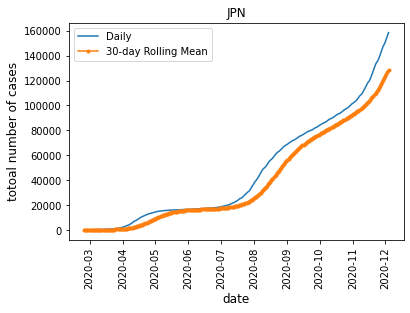

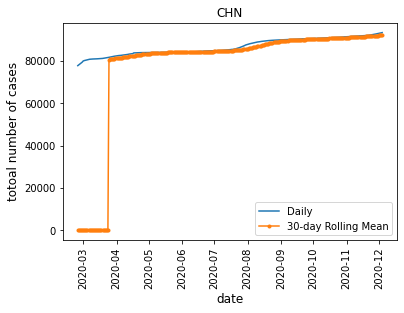

In [ ]:
# rolling for cumulative => solution for the problem of late registration of data or non-granularity

for country,df in dfs.items():
    df_30day_rolling = df["confirmed"].rolling(30).mean().fillna(0)
    plt.figure()
    plt.plot(df.date, df["confirmed"], label="Daily")
    plt.plot(df.date, df_30day_rolling, marker=".", label="30-day Rolling Mean")
    plt.xticks(rotation=90)
    plt.xlabel("date", size=12)
    plt.ylabel("totoal number of cases", size=12)
    plt.title(country)
    plt.legend()
    plt.show()

### Per period

In [ ]:
mid_period = ("2020-06-12", "2020-10-12")  # arbitrarily chosen, subject to change             
first_period = (start_date, mid_period[0]) # beginning of pandemic
last_period = (mid_period[1], arrow.get(end_date)) # most recent 

In [ ]:
test = dfs["CHE"]
test[test.index > mid_period[0]]

,confirmed,date,deaths,recovered,ts_in_secs,new_confirmed,month
date,,,,,,,
2020-06-13 00:00:00+00:00,31094,2020-06-13,1938,28800,1592006400000000000,31.0,2020-06
2020-06-14 00:00:00+00:00,31117,2020-06-14,1938,28800,1592092800000000000,23.0,2020-06
2020-06-15 00:00:00+00:00,31131,2020-06-15,1939,28900,1592179200000000000,14.0,2020-06
2020-06-16 00:00:00+00:00,31154,2020-06-16,1954,28900,1592265600000000000,23.0,2020-06
2020-06-17 00:00:00+00:00,31187,2020-06-17,1956,28900,1592352000000000000,33.0,2020-06
...,...,...,...,...,...,...,...
2020-11-30 00:00:00+00:00,327072,2020-11-30,4815,250200,1606694400000000000,8782.0,2020-11
2020-12-01 00:00:00+00:00,330874,2020-12-01,4940,250200,1606780800000000000,3802.0,2020-12
2020-12-02 00:00:00+00:00,335660,2020-12-02,5045,257600,1606867200000000000,4786.0,2020-12


In [ ]:
for country,df in dfs.items():
  # ...
  ...

In [ ]:
# China vs Japan
# ...


# US vs CH
# ...